<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Authors: Vitaly Radchenko (@vradchenko), [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Volkov (@sevaspb). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #3. Spring 2019
## <center> Part 2. Random Forest and Logistic Regression in credit scoring and movie reviews classification
 
Random Forest and logistic regression are two algorithms that I personally use most often in day-to-day DS tasks. In this part of the assignment, we'll explore pros and cons of these two algorithms in two different tasks. 
 
Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/video](https://mlcourse.ai/video) 

### Your task is to:
 1. write code and perform computations in the cells below
 2. choose answers in the [webform](https://docs.google.com/forms/d/1UupRN8TS7C9-lfD7OlgJzmD0ZfNe1dKUSLLaTnUokMw/edit). Solutions will be shared only with those who've filled in this form 
 
### <center> Deadline for A3: 2019 March 31, 20:59 GMT (London time)

For the warm-up, solve the first task (in the first part there are 5 questions, web-form is the same for two parts, so we start counting from 6).

<font color = 'red'> **Question 6:** </font> There are 9 jurors in the courtroom. Each of them individually can correctly determine whether the defendant is guilty or not with 75% probability. What is the probability that the jurors will jointly reach the correct verdict if the final decision is made by majority vote?

<font color = 'red'> **Answer options:** </font>
- 60.97%
- 80.00%
- 95.11% [+]
- 96.66% 

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q6-10__*

In [1]:
N = 9
p = 0.75


def fac(n):
    if n == 1 or n == 0:
        val =  1
    else:
        val = n * fac(n-1)
    return val

prob = 0
for i in range((N + 1) // 2, N + 1):
    prob += fac(N) / fac(i) / fac(N-i) * (p ** i) * ((1 - p) ** (N - i))

print(round(prob, 4) * 100)
    

95.11


Now let's move directly to machine learning.

#### Problem

Predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

#### Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let us implement a function that will replace the NaN values by the median in each column of the table.

In [3]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Reading the data:

In [4]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


View data types of the features:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Look at the distribution of the target variable:

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

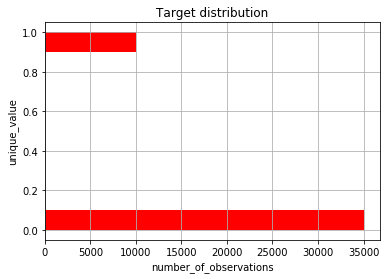

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts(normalize=True) 

Select all the features and drop the target:

In [7]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

We apply a function that replaces all NaN values with the median value of the corresponding feature.

In [8]:
table = impute_nan_with_median(data)

Split the target and features - now we get a training set.

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

# Bootstrap

**<font color = 'red'> Question 7. </font>** Make an interval estimate based on the bootstrap (2000 samples) of the average income (MonthlyIncome)  of customers who had overdue loan payments, and of those who paid in time, make 80% confidence interval. Use target value (SeriousDlqin2yrs) to split data. Find the difference between the lower limit of the derived interval for those who paid in time and the upper limit for those who are overdue.
So, you are asked to build 80% intervals for the income of "good" customers $ [good\_income\_lower, good\_income\_upper] $ and for "bad" - $ [bad\_income\_lower, bad\_income\_upper] $ and find the difference $ good\_income\_upper - bad\_income\_lower $.

Use the example from the [article](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7). Set `np.random.seed(17)`. Round your answer to the closest integer.

**<font color='red'>Answer options:</font>**
- 654
- 714
- 834 
- 996 [+]

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q6-10__*

In [10]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [11]:
# you'll be asked to fix this seed (`random_state`) everywhere in this notebook

data_bad = X[y == 1]['MonthlyIncome'].values
data_good = X[y == 0]['MonthlyIncome'].values

SEED = 17
np.random.seed(SEED)

bad_mean_scores = [np.mean(sample) 
                   for sample in get_bootstrap_samples(data_bad, 2000)]
good_mean_scores = [np.mean(sample) 
                    for sample in get_bootstrap_samples(data_good, 2000)]

int(stat_intervals(good_mean_scores, 0.2)[1] - stat_intervals(bad_mean_scores, 0.2)[0])

996


# Decision tree, hyperparameter tuning

One of the main performance metrics of a model is the area under the ROC curve. The ROC-AUC values lay between 0 and 1. The closer the value of ROC-AUC to 1, the better the classification is done.

Find the values of `DecisionTreeClassifier` hyperparameters using the `GridSearchCV`, which maximize the area under the ROC curve.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Use the `DecisionTreeClassifier` class to create a decision tree. Due to the imbalance of the classes in the target, we add the balancing parameter. We also use the parameter `random_state = 17` for the reproducibility of the results.

In [13]:
dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')

We will look through such values of hyperparameters:

In [14]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Fix cross-validation parameters: stratified, 5 partitions with shuffle, 
`random_state`. We will use this splitting throughout the notebook.

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

**<font color='red'>Question 8.</font>**
Run GridSearch with the ROC AUC metric using the hyperparameters from the `tree_params` dictionary. What is the maximum ROC AUC value (round up to 2 decimals)? We call cross-validation stable if the standard deviation of the metric on the cross-validation is less than 0.01. Was cross-validation stable under optimal combinations of hyperparameters (i.e., providing a maximum of the mean ROC AUC value for cross-validation)?

**<font color='red'>Answer options:</font>**
- 0.82, no
- 0.84, no
- 0.82, yes [+]
- 0.84, yes

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q6-10__*

In [16]:
gs = GridSearchCV(estimator=dt, param_grid=tree_params, cv=skf, scoring='roc_auc', return_train_score=True)
gs.fit(X, y)

print(gs.best_params_)

print(
    round(gs.cv_results_['mean_test_score'][gs.best_index_], 2),
    ', ',
    'yes' if gs.cv_results_['std_test_score'][gs.best_index_] < 0.01 else 'no'
)

{'max_depth': 7, 'max_features': 6}
0.82 ,  yes


# Simple RandomForest implementation

**<font color='red'>Question 9.</font>**
Implement your own random forest using `DecisionTreeClassifier` with the best parameters from the previous task. There will be 10 trees, the predicted probabilities of which you need to average.

Brief specification:
 - Use the base code below
 - In the `fit` method in the loop (`i` from 0 to `n_estimators-1`):
   * fix the seed equal to (`random_state + i`). The idea is that at each iteration there's a new value of random seed to add more "randomness", but at the same time results are reproducible
   * After fixing the seed, select `max_features` features **without replacement**, save the list of selected feature ids in `self.feat_ids_by_tree`
   * Also make a bootstrap sample (i.e. **sampling with replacement**) of training instances. For that, resort to `np.random.choice` and its argument `replace`
   * Train a decision tree with specified (in a constructor) arguments `max_depth`, `max_features` and `random_state` (do not specify `class_weight`) on a corresponding subset of training data. 
 - The `fit` method returns the current instance of the class `RandomForestClassifierCustom`, that is `self`
 - In the `predict_proba` method, we need to loop through all the trees. For each prediction, obviously, we need to take only those features which we used for training the corresponding tree. The method returns predicted probabilities (`predict_proba`), averaged for all trees

Perform cross-validation with `StratifiedKFold`.  What is the average cross-validation ROC AUC of the custom Random Forest implementation? Select the closest value.

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q6-10__*

**<font color='red'>Answer options:</font>**
- 0.823
- 0.833 [+]
- 0.843
- 0.853

In [89]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=10, max_features=10, 
                 random_state=SEED):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        
        self.trees = []
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        self.trees = []
        self.feat_ids_by_tree = []
        
        for i in range(self.n_estimators):
            seed = self.random_state + i
            np.random.seed(seed)
            
            features = np.random.choice(X.columns.values, size=self.max_features, replace=False)
            rows = np.random.choice(X.index.values, size=X.shape[0], replace=True)

            clf = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state + i,
            )
            
            clf.fit(X[features].loc[rows], y[rows])

            self.feat_ids_by_tree.append(features)                                     
            self.trees.append(clf)
            
        return self

    
    def predict_proba(self, X):
        preds = pd.DataFrame()

        for i in range(self.n_estimators):
            pred = self.trees[i].predict_proba(
                X[self.feat_ids_by_tree[i]]
            )
            
            

            preds[i] = pred[:, 1]

        pred_1 = preds.mean(axis=1).values
        return np.array([1 - pred_1, pred_1]).T

In [90]:
forest = RandomForestClassifierCustom(n_estimators=10, max_depth=7, max_features=6)

gs = GridSearchCV(estimator=forest, param_grid={}, cv=skf, scoring='roc_auc', return_train_score=True)
gs.fit(X, y)

round(gs.cv_results_['mean_test_score'][0], 3)

0.832

**<font color='red'>Question 10.</font>**
Let us compare our own implementation of a random forest with `sklearn` version of it. To do this, use `RandomForestClassifier (class_weight='balanced', n_estimators=10, random_state=17)`, specify all the same values for `max_depth` and `max_features` as before. What average value of ROC AUC on cross-validation we finally got? Select the closest value.

**<font color='red'>Answer options:</font>**
- 0.814
- 0.827 [+]
- 0.843
- 0.856

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q6-10__*

In [95]:
from sklearn.ensemble import RandomForestClassifier

In [96]:
frs = RandomForestClassifier(class_weight='balanced', n_estimators=10, random_state=17, max_depth=7, max_features=6)
gs = GridSearchCV(estimator=frs, param_grid={}, cv=skf, scoring='roc_auc', return_train_score=True)
gs.fit(X, y)

round(gs.cv_results_['mean_test_score'][0], 3)

0.829

# `sklearn` RandomForest, hyperparameter tuning

**<font color='red'>Question 11.</font>** 
In the third task, we found the optimal hyperparameters for one tree. However it could be that these parameters are not optimal for an ensemble. Let's check this assumption with `GridSearchCV` `(RandomForestClassifier (class_weight='balanced', n_estimators=10, random_state=17)` ). Now we extend the value of `max_depth` up to 15, because the trees need to be deeper in the forest (you should be aware of it from the [article](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7)). What are the best values of hyperparameters now?

**<font color='red'>Answer options:</font>**
- `max_depth=8, max_features=4` [+]
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q11-14__*

In [101]:
max_depth_values = range(5, 15)
max_features_values = [4, 5, 6, 7]
forest_params = {
    'max_depth': max_depth_values,
    'max_features': max_features_values
}

In [102]:
clf = RandomForestClassifier(class_weight='balanced', n_estimators=10, random_state=17)

gs = GridSearchCV(estimator=frs, param_grid=forest_params, cv=skf, scoring='roc_auc', return_train_score=True)
gs.fit(X, y)

gs.best_params_

KeyboardInterrupt: 

# Logistic regression, hyperparameter tuning

**<font color='red'>Question 12.</font>**  Now let's compare our results with logistic regression (we indicate `class_weight = 'balanced'`, `solver='liblinear'` and `random_state=17`). Do a full search by the parameter `C` from a wide range of values `np.logspace (-8, 8, 17)`.
Now we will build a pipeline - first apply scaling, then train the model.

Learn about the pipelines and make cross-validation. What is the best average ROC AUC? Select the closest value.

**<font color='red'>Answer options:</font>**
- 0.788 [+]
- 0.798
- 0.808
- 0.818

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q11-14__*

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [100]:
gs = GridSearchCV(estimator=logit_pipe, param_grid=logit_pipe_params, cv=skf, scoring='roc_auc', return_train_score=True)
gs.fit(X, y)

gs.best_score_

/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.p

/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: Dat

/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: Dat

/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: Dat

/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: Dat

/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: Dat

/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: Dat

/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: Dat

/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/m.yuldashev/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:401: Dat

0.7878626757307206

# Logistic regression and RandomForest on sparse features

In case of a small number of features, random forest was proved to be better than logistic regression. However, one of the main disadvantages of trees is how they work with sparse data, for example, with texts. Let's compare logistic regression and random forest in a new task.
Download the dataset with movie reviews from [here](https://drive.google.com/file/d/1WDz3EB0MMuQUuUTwZ30c4JJrN8d9shAW/view?usp=sharing). 

In [104]:
# Download data
df = pd.read_csv("../../data/movie_reviews_train.csv.zip", nrows=50000)

# Split data to train and test
X_text = df["text"]
y_text = df["label"]

# Classes counts
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# In Pipeline we will modify the text and train logistic regression
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', LogisticRegression(solver='liblinear', random_state=SEED))])

**<font color='red'>Question  13.</font>** For Logistic Regression: iterate parameter `C` with values from the list [0.1, 1, 10, 100] and find the best ROC AUC in cross-validation. Select the closest answer.

**<font color='red'>Answer options:</font>**
- 0.71
- 0.75
- 0.81
- 0.85 [+]

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q11-14__*

In [109]:
params = {
    'clf__C':  [0.1, 1, 10, 100],
}

gs = GridSearchCV(estimator=classifier, param_grid=params, cv=skf, scoring='roc_auc', return_train_score=True)
gs.fit(X_text, y_text)

round(gs.best_score_, 2)

0.86

**<font color='red'>Question 14.</font>** Now try to perform the same operation with random forest. Similarly, look over all the values and get the maximum ROC AUC, select the closest value. Keep in mind that in this case training may take a lot of time (up to ah hour). 

**<font color='red'>Answer options:</font>**
- 0.71
- 0.75 [+]
- 0.81
- 0.85

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q11-14__*

In [110]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', RandomForestClassifier(n_estimators=10, random_state=SEED, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [111]:
params = {
    'clf__min_samples_leaf': min_samples_leaf,
    'clf__max_features': max_features,
}

gs = GridSearchCV(estimator=classifier, param_grid=params, cv=skf, scoring='roc_auc', return_train_score=True)
gs.fit(X_text, y_text)

round(gs.best_score_, 2)

0.75